# Pseudo-random numbers language model

The following notebook builds a language model for data generated with deep-zoom method as described in Machicao, J., & Bruno, O. M. (2017). [Improving the pseudo-randomness properties of chaotic maps using deep-zoom](https://doi.org/10.1063/1.4983836). Chaos: An Interdisciplinary Journal of Nonlinear Science, 27(5), 53116.

## Dataset

Data consists of a training set and a test set, each with 100 sample files divided in 11 classes.

Each class corresponds to sequences generated with the deep zoom method using a different value of k, respectively from k=0 to k=10

Each sample file contains a sequence of one million digits produced using deep zoom with the corresponding value of k.

Files are in text format, using the following naming convention:
/{Train|Test}/k{k}/k{k}-parte{0-99}.ser

## RNN model for sequence learning

In this experiment, a Recurrent Neural Network is trained to encode a language model of the data in each class of pseudo-random generated digits. A language model tries to represent the probability of a given sequence, usually as the product of the probability of the single units (in our case, single digits) given the previous ones -- i.e. assuming probabilistical independence. 

The following class `RNNLanguageModel` implements a Recurrent Neural Network with n-layers of GRU cells in order to model the "language patterns" that might be found in the data. The network is fed with batches of `{batch_size}` sequences of `{step_size}` digits one-hot-encoded as `{vocab_size}`-dimensional vectors. The output is a matrix of  `{vocab_size}`-dimensional probability vectors, one for each of the `{batch_size x step_size}` digits in the batch.

In each batch, every sequence continues where the corresponding one ended in the previous batch. The state of the RNN cells -- and thus the previous context -- is saved between batches. Thus, the step size does not affect the final result and is rather determined by available GPU memory limitations.

The optimization objective is set to minimize softmax cross-entropy, i.e. to minimize the distance between the learned probability distribution and the empirical distribution found in the data.

No regularization techniques have been needed yet for the following reasons:
* Given the great amount of available data, for the moment the network is made to see each sequence once.
* Given the pseudo-random nature of the data, predictions are far away from high accuracy.

In [1]:
#
# RNN model for sequence learning
#
import tensorflow as tf
import numpy as np
import os
from tensorflow.contrib import rnn
from tensorflow.contrib import layers
from datetime import datetime
from tqdm import trange, tqdm
tqdm.monitor_interval = 0

class RNNLanguageModel(object):
  
  def __init__(self,
               vocab_size = 10,
               num_units = 2048,
               num_layers = 3,
               step_size = 32,
               batch_size = 192,
               log_dir = '/tmp/RNNLanguageModel/prueba'):
    
    self.vocab_size = vocab_size
    self.num_units = num_units
    self.num_layers = num_layers
    self.step_size = step_size
    self.log_dir = log_dir
    self.batch_size = batch_size

    tf.reset_default_graph()
    tf.set_random_seed(0)

    #
    # model graph
    #
    with tf.name_scope("input_layer"):
      X = tf.placeholder(tf.uint8, [batch_size, step_size], name='X')  # [ batch_size, step_size ]
      Y = tf.placeholder(tf.uint8, [batch_size, step_size], name='Y')  # [ batch_size, step_size ]
      X_one_hot = tf.one_hot(X, vocab_size, 1.0, 0.0)       # [ batch_size, step_size, vocab_size ]
      Y_one_hot = tf.one_hot(Y, vocab_size, 1.0, 0.0)       # [ batch_size, step_size, vocab_size ]

    with tf.name_scope("hidden_layers"):
      multicell = rnn.MultiRNNCell([rnn.GRUCell(num_units) for _ in range(num_layers)])
      initial_state = multicell.zero_state(batch_size, dtype=tf.float32)     # num_layers x [batch_size, num_units]
      hidden_outputs, hidden_states = tf.nn.dynamic_rnn(multicell, X_one_hot, dtype=tf.float32, initial_state=initial_state)
      # outputs:   [ batch_size, step_size, num_units ]
      # states:    [ num_layers, batch_size, num_units ]
      
    with tf.name_scope("output_layer"):
      hidden_outputs_flat = tf.reshape(hidden_outputs, [-1, num_units]) # [ batch_size x step_size, num_units ]
      logits_flat = layers.linear(hidden_outputs_flat, vocab_size)      # [ batch_size x step_size, vocab_size ]
      Y_hat_probs_flat = tf.nn.softmax(logits_flat)                     # [ batch_size x step_size, vocab_size ]
      Y_hat_flat = tf.cast(tf.argmax(Y_hat_probs_flat, 1), tf.uint8)    # [ batch_size x step_size ]
      
      
    with tf.name_scope("train"):
      Y_one_hot_flat = tf.reshape(Y_one_hot, [-1, vocab_size])          # [ batch_size x step_size, num_units ]
      cost = tf.nn.softmax_cross_entropy_with_logits(labels=Y_one_hot_flat, logits=logits_flat)  # [ batch_size x step_size ]
      loss = tf.reduce_mean(cost)
      optimizer = tf.train.AdamOptimizer()
      training_op = optimizer.minimize(loss)

    with tf.name_scope("eval"):
      Y_flat = tf.reshape(Y, [-1])          # [ batch_size x step_size ]
      accuracy = tf.reduce_mean(tf.cast(tf.equal(Y_flat, Y_hat_flat), tf.float32))
      likelihood_flat = tf.reduce_sum(tf.multiply(Y_hat_probs_flat, Y_one_hot_flat), 1)  # [ batch_size x step_size ]
      mean_likelihood = tf.reduce_mean(likelihood_flat)

    with tf.name_scope("summaries"):
      loss_summary = tf.summary.scalar('loss', loss)
      acc_summary = tf.summary.scalar('accuracy', accuracy)
      ml_summary = tf.summary.scalar('mean_likelihood', mean_likelihood)
      merged_summary = tf.summary.merge_all()      

    #
    # public graph nodes 
    #
    self.X = X
    self.Y = Y
    self.initial_state = initial_state
    self.hidden_states = hidden_states
    self.Y_hat_probs_flat = Y_hat_probs_flat
    self.Y_hat_flat = Y_hat_flat
    self.loss = loss
    self.training_op = training_op
    self.accuracy = accuracy
    self.mean_likelihood = mean_likelihood
    self.merged_summary = merged_summary
  
  
  def data_sequencer(self, data):
    _data = np.array(data)
    data_len = _data.shape[0]
    num_steps = (data_len - 1) // (self.step_size * self.batch_size)
    assert num_steps > 0
    data_len_used = self.step_size * self.batch_size * num_steps
    _xdata = np.reshape(_data[0:data_len_used], [self.batch_size, self.step_size * num_steps])
    _ydata = np.reshape(_data[1:data_len_used+1], [self.batch_size, self.step_size * num_steps])
    
    for i in trange(num_steps):
      x = _xdata[:, i * self.step_size: (i + 1) * self.step_size]
      y = _ydata[:, i * self.step_size: (i + 1) * self.step_size]
      yield x, y

      
  def fit(self, data, restore_checkpoint=True, step_offset=None, train_logdir=None):
    time_string = datetime.now().strftime("%Y%m%d-%H%M%S")
    if not(train_logdir):
      train_logdir = "{}/{}-train".format(self.log_dir, time_string)
    save_dir = "{}/checkpoints".format(self.log_dir)
    train_file_writer = tf.summary.FileWriter(train_logdir, tf.get_default_graph())
   
    if not os.path.exists(save_dir):
      os.mkdir(save_dir)
    saver = tf.train.Saver(max_to_keep=1)

    with tf.Session() as sess: 
      latest_checkpoint = tf.train.latest_checkpoint(save_dir)
      if restore_checkpoint & (latest_checkpoint is not None):
        saver.restore(sess, latest_checkpoint)
      else:
        tf.global_variables_initializer().run()
      
      init_state = sess.run(self.initial_state)
      cur_step = 1
      if step_offset:
        cur_step += step_offset
      
      print('Initiating model fit...')
      print('Data length     : {}'.format(len(data)))
      print('Step size       : {}'.format(self.step_size))
      print('Batch size      : {}'.format(self.batch_size))
      print('Hidden layers   : {}'.format(self.num_layers))
      print('Units per layer : {}'.format(self.num_units))
      print('Run dir         : {}'.format(train_logdir))
    
      for x, y in self.data_sequencer(data):
        feed_dict={self.X: x, self.Y: y}
        for i, v in enumerate(self.initial_state):
            feed_dict[v] = init_state[i]
        _, last_state, summary = sess.run([self.training_op, self.hidden_states, self.merged_summary], 
                                                       feed_dict=feed_dict)
        train_file_writer.add_summary(summary, cur_step)
        
        if cur_step % 50 == 0:
            saver.save(sess, "{}/{}-{}".format(save_dir, time_string, cur_step), global_step=cur_step)

        init_state = last_state
        cur_step += 1
      
      saver.save(sess, "{}/{}-{}".format(save_dir, time_string, cur_step), global_step=cur_step)
 
        
  def eval(self, data):
    time_string = datetime.now().strftime("%Y%m%d-%H%M%S")
    eval_logdir = "{}/{}-eval".format(self.log_dir, time_string)
    save_dir = "{}/checkpoints".format(self.log_dir)
    eval_file_writer = tf.summary.FileWriter(eval_logdir)

    saver = tf.train.Saver(max_to_keep=1)

    with tf.Session() as sess: 
      latest_checkpoint = tf.train.latest_checkpoint(save_dir)
      assert (latest_checkpoint is not None)
      saver.restore(sess, latest_checkpoint)
      
      init_state = sess.run(self.initial_state)
      cur_step = 1
      
      accuracy_history = []
      mean_likelihood_history = []
      loss_history = []
      
      print('Evaluating model...')
      print('Data length     : {}'.format(len(data)))
      print('Run dir         : {}'.format(eval_logdir))

      for x, y in self.data_sequencer(data):
        feed_dict={self.X: x, self.Y: y}
        for i, v in enumerate(self.initial_state):
            feed_dict[v] = init_state[i]
        _accuracy, _mean_likelihood, _loss, last_state, summary = sess.run([self.accuracy,
                                                                     self.mean_likelihood,
                                                                     self.loss,
                                                                     self.hidden_states, 
                                                                     self.merged_summary], 
                                                                    feed_dict=feed_dict)
        eval_file_writer.add_summary(summary, cur_step)
        accuracy_history += [_accuracy]
        mean_likelihood_history += [_mean_likelihood]
        loss_history += [_loss]
        
        init_state = last_state
        cur_step += 1

      eval_accuracy = np.mean(accuracy_history)
      eval_perplexity = np.exp(np.mean(loss_history))
      eval_mean_likelihood = np.mean(mean_likelihood_history)
      
      print('Accuracy        : {:.04f}'.format(eval_accuracy))
      print('Perplexity      : {:.04f}'.format(eval_perplexity))
      print('Mean likelihood : {:.04f}'.format(eval_mean_likelihood))
      
      return eval_accuracy, eval_perplexity, eval_mean_likelihood
    
    
  def eval_classes(self,
                   ks = [0, 3, 6, 9], 
                   sample_size = 192 * 32 + 1, 
                   num_samples_per_k = 3, 
                   path_pattern = 'data/DatasetKlogmap/Test/k%d/k%d-parte%d.ser', 
                   file_len = 1000000):
    print('k\tFile#\tOffset\tAccuracy\tMean likelihood')
    for k in ks:
      for i in range(num_samples_per_k):
        file_number = np.random.randint(100)
        file_offset = np.random.randint(file_len - sample_size)
        data = load_data(k, path_pattern, [file_number])[file_offset:file_offset+sample_size]
        acc, ml = model.eval(data)
        print(k, file_number, file_offset, acc, ml)

        

#
# Utility function for selectively loading the content of training or test sample files into a single memory array
#

import numpy as np
from tqdm import tqdm

TRAIN_PATTERN = 'data/DatasetKlogmap/Train/k%d/k%d-parte%d.ser'
TEST_PATTERN = 'data/DatasetKlogmap/Test/k%d/k%d-parte%d.ser'

def load_data(k, path_pattern=TRAIN_PATTERN, indices=[0]):
  data = []
  print('Loading data for k=%d, indices=' % k, indices)
  for i in tqdm(indices):
    with open(path_pattern % (k, k, i), 'r') as f:
      data += [int(i) for i in f.read()]
  return data


#
# Utility functions for plotting summary data exported from TensorBoard as csv files
#

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

def plot_graph_from_tensorboard_csv(filename, 
                                    title, 
                                    xlabel = 'Millions of digits seen', 
                                    xcol = 'Step', 
                                    ycol = 'Value', 
                                    format_string = 'r', 
                                    batch_data_size = 32 * 192,
                                    cross_entropy_to_perplexity = False,
                                    ylim = None,
                                    step_range = None
                                   ):
  df = pd.read_csv(filename)
  if cross_entropy_to_perplexity:
    df[ycol] = np.exp( df[ycol])
  if step_range:
    start, end = step_range
    df = df[start:end]
  if ylim:
    plt.ylim(ylim)
  plt.plot(df[xcol] * batch_data_size, df[ycol], format_string)
  plt.title(title + ' ~ {:.04f}'.format(np.mean(df[ycol][-1000:])) )
  plt.xlabel(xlabel)

def plot_graphs(file_prefix, 
                step_size = 32, 
                batch_size = 192, 
                main_title = None, 
                step_range = None, 
                fit_y_scale_to_data = False,
                marker = ''
               ):
  plt.figure(figsize=(16,4))
  plt.tight_layout()
  if main_title:
    plt.suptitle(main_title, size=16)
    plt.subplots_adjust(top=0.82) 
  
  ylim = None
  plt.subplot(1, 3, 1)
  if not(fit_y_scale_to_data):
    ylim = (0,1)
  plot_graph_from_tensorboard_csv(filename = file_prefix + '-tag-summaries_accuracy.csv',
                                  title = 'Accuracy',
                                  format_string = 'r' + marker,
                                  batch_data_size = step_size * batch_size / 1000000, 
                                  ylim = ylim, 
                                  step_range = step_range
                               )

  plt.subplot(1, 3, 2)
  ylim = None
  plot_graph_from_tensorboard_csv(filename = file_prefix + '-tag-summaries_loss.csv',
                                  title = 'Perplexity',
                                  format_string = 'g' + marker,
                                  batch_data_size = step_size * batch_size / 1000000,
                                  cross_entropy_to_perplexity = True,
                                  ylim = ylim, 
                                  step_range = step_range
                               )
  
  plt.subplot(1, 3, 3)
  plt.yscale('linear')
  if not(fit_y_scale_to_data):
    ylim = (0,1)
  plot_graph_from_tensorboard_csv(filename = file_prefix + '-tag-summaries_mean_likelihood.csv',
                                  title = 'Mean Likelihood',
                                  format_string = 'b' + marker,
                                  batch_data_size = step_size * batch_size / 1000000,
                                  ylim = ylim, 
                                  step_range = step_range
                               )

#
# Utility function for estimating empirical frequencies 'signature'
#

import numpy as np
import pandas as pd
from tqdm import trange
tqdm.monitor_interval = 0

def empirical_frequencies(data,
                          chunk_size = 1000,
                          classes = np.arange(10)
                         ):
  data_len = len(data)
  num_chunks = data_len // chunk_size
  assert num_chunks > 0, 'Chunk size greater than data length'

  empirical_frequencies = np.zeros((num_chunks, len(classes)))
  
  print('Calculating empirical frequencies for {} chunks of size {}'.format(num_chunks, chunk_size))
  
  for i in trange(num_chunks):
    chunk = data[i * chunk_size: (i + 1) * chunk_size]
    empirical_frequencies[i] = [chunk.count(x) / chunk_size for x in classes]
    
  mu = np.mean(empirical_frequencies, 0)
  sigma = np.std(empirical_frequencies, 0)
  
  df = pd.DataFrame({'Mean frequency': mu, 'Standard dev': sigma})
  
  return df

## Training, validation and experiments

Training will begin with simple experimentation, followed by other setups suggested by the results.  

### [k=0, 20 first training samples]

A simple calculation of relative frequencies of the digits in class k=0 reveals that 0 and 9 are more frequent. This follows a pattern described in the reference paper, and suggests that each digit is being generated by scaling the n-th orbit by a factor of 10 and rounding.

Additionaly, the frequencies imply that a majority class baseline for accuracy would be approximately 0.20.

In [2]:
empirical_frequencies(load_data(k=0, indices=range(20)))

Loading data for k=0, indices= range(0, 20)


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.04s/it]


Calculating empirical frequencies for 20000 chunks of size 1000


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:29<00:00, 222.96it/s]


,Mean frequency,Standard dev
0,0.204868,0.016464
1,0.090254,0.009013
2,0.073893,0.006156
3,0.066858,0.008217
4,0.064085,0.007093
5,0.064079,0.006169
6,0.066906,0.007153
7,0.073900,0.012750
8,0.090381,0.005419
9,0.204775,0.006217


After training a model with only 20 sample files (for a total of 20 million digits) we observe that some clear patterns are identified. Accuracy increases rapidly up to ~0.67, with a perplexity of ~2. (A perplexity of 10 would be expected for a uniform random guess in a uniformly random 10-class sample.) We also measure the mean likelihood predicted by the model to each digit in the sequence.

All training metrics converge to a stable value with very low variance after ~600K digits.

In [12]:
model = RNNLanguageModel(log_dir = '/tmp/RNNLanguageModel/k0')
model.fit(load_data(k=0, indices=range(20)))

Loading data for k=0, indices= range(0, 20)


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.13it/s]


Initiating model fit...
Data length  : 20000000
Step size    : 32
Batch size   : 192
Run dir      : /tmp/RNNLanguageModel/k0/20180129-000608-train


100%|████████████████████████████████████████████████████████████████████████████| 3255/3255 [3:19:06<00:00,  3.67s/it]


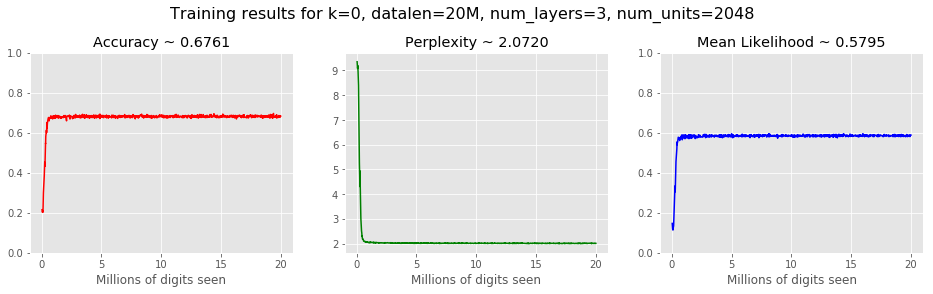

In [60]:
plot_graphs('data/results/run_20180129-000608-train', 
                         main_title = 'Training results for k=0, datalen=20M, num_layers=3, num_units=2048')

Validation with previously unseen data confirms that there is no overfitting and that metrics converge to values pretty close to training.

In [41]:
model = RNNLanguageModel(log_dir = '/tmp/RNNLanguageModel/k0')
model.eval(load_data(k=0, indices=[99]))

Loading data for k=0, indices= [99]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


INFO:tensorflow:Restoring parameters from /tmp/RNNLanguageModel/k0/checkpoints/20180129-000608-3256-3256
Evaluating model...
Data length     : 1000000
Run dir         : /tmp/RNNLanguageModel/k0/20180130-195610-eval


100%|████████████████████████████████████████████████████████████████████████████████| 162/162 [03:09<00:00,  1.17s/it]


Accuracy        : 0.6814
Perplexity      : 2.0062
Mean likelihood : 0.5882


(0.68141156, 2.006218, 0.58823246)

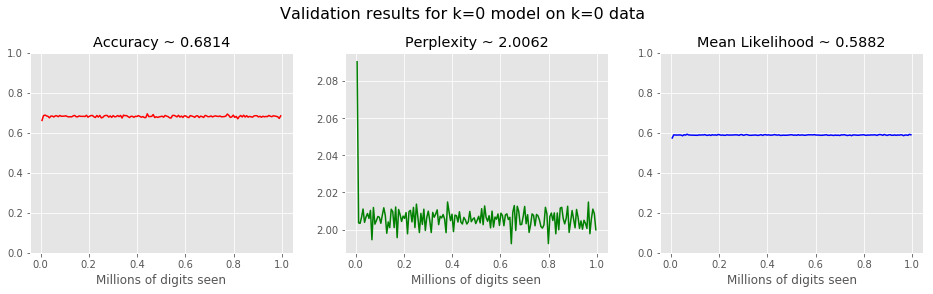

In [61]:
plot_graphs('data/results/run_20180130-195610-eval', 
                         main_title = 'Validation results for k=0 model on k=0 data')

A zoom in the first 10 steps (~ 61K digits) shows that convergence level is reached after just one step.

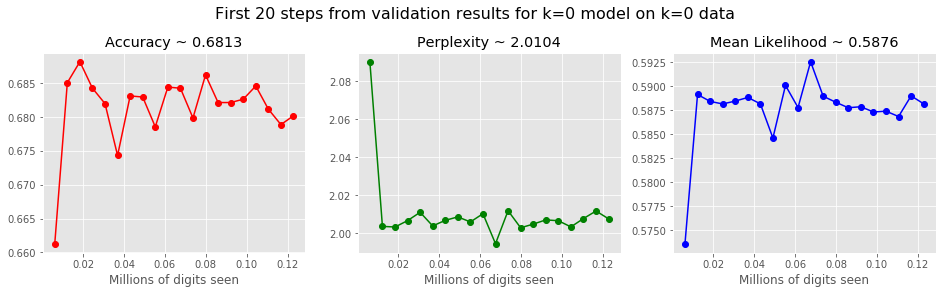

In [11]:
plot_graphs('data/results/run_20180130-195610-eval',
            main_title = 'First 20 steps from validation results for k=0 model on k=0 data',
            step_range = (0,20),
            fit_y_scale_to_data = True,
            marker = 'o-'
           )

Preliminary experiments showed that a model did better than an accuracy of 0.10 when exposed to a different class, which would have suggested that patterns in a class could be shared by an adjacent one, or even that k=n model could be used to initialize k=n+1 training. We run the k=0 model on the k=1 data and observe that accuracy for k=0 model and k=1 data (0.1482) is somewhat higher than majority class baseline (0.1342 for digit 9), but perplexity gets too high, meaning that model errors were wrongly predicted with too high confidence, which implies a too distant model distribution.

In [3]:
empirical_frequencies(load_data(k=1, indices=range(20)))

Loading data for k=1, indices= range(0, 20)


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.06s/it]


Calculating empirical frequencies for 20000 chunks of size 1000


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:27<00:00, 228.95it/s]


,Mean frequency,Standard dev
0,0.134190,0.014347
1,0.097214,0.009478
2,0.091595,0.008338
3,0.089089,0.009227
4,0.087973,0.008518
5,0.088007,0.008755
6,0.089004,0.008801
7,0.091504,0.010755
8,0.097173,0.008616
9,0.134252,0.008592


In [56]:
model = RNNLanguageModel(log_dir = '/tmp/RNNLanguageModel/k0')
model.eval(load_data(k=1, indices=[99]))

Loading data for k=1, indices= [99]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


INFO:tensorflow:Restoring parameters from /tmp/RNNLanguageModel/k0/checkpoints/20180129-000608-3256-3256
Evaluating model...
Data length     : 1000000
Run dir         : /tmp/RNNLanguageModel/k0/20180130-202538-eval


100%|████████████████████████████████████████████████████████████████████████████████| 162/162 [03:09<00:00,  1.17s/it]


Accuracy        : 0.1482
Perplexity      : 430.4453
Mean likelihood : 0.1266


(0.14820442, 430.44531, 0.12658952)

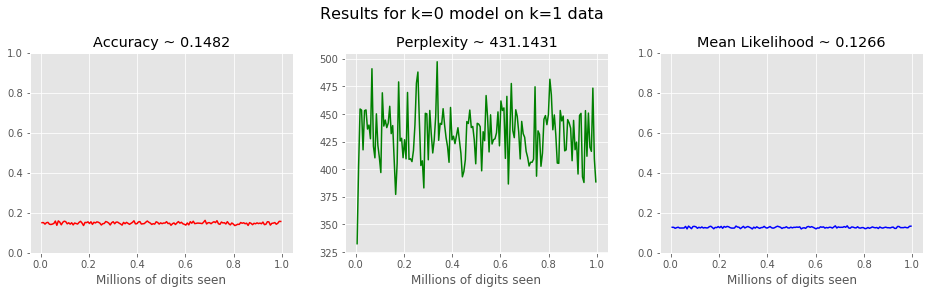

In [95]:
plot_graphs('data/results/run_20180130-202538-eval', 
                         main_title = 'Results for k=0 model on k=1 data')

### [k=1, 20 first training samples]

Results for k=1 are similar to k=0, still with noticeable pattern identification, but with a relatively diminished performance.

Training metrics now take ~1M digits to reach a relative plateau.

In [4]:
empirical_frequencies(load_data(k=1, indices=range(20)))

Loading data for k=1, indices= range(0, 20)


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.00s/it]


Calculating empirical frequencies for 20000 chunks of size 1000


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:22<00:00, 241.01it/s]


,Mean frequency,Standard dev
0,0.134190,0.014347
1,0.097214,0.009478
2,0.091595,0.008338
3,0.089089,0.009227
4,0.087973,0.008518
5,0.088007,0.008755
6,0.089004,0.008801
7,0.091504,0.010755
8,0.097173,0.008616
9,0.134252,0.008592


In [16]:
model = RNNLanguageModel(log_dir = '/tmp/RNNLanguageModel/k1')
model.fit(load_data(k=1, indices=range(20)))

Loading data for k=1, indices= range(0, 20)


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.01s/it]


Initiating model fit...
Data length  : 20000000
Step size    : 32
Batch size   : 192
Run dir      : /tmp/RNNLanguageModel/k1/20180129-132650-train


100%|████████████████████████████████████████████████████████████████████████████| 3255/3255 [3:19:16<00:00,  3.67s/it]


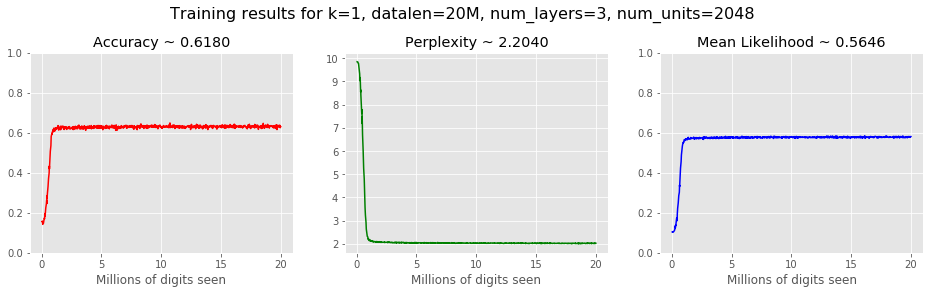

In [64]:
plot_graphs('data/results/run_20180129-132650-train', 
                         main_title = 'Training results for k=1, datalen=20M, num_layers=3, num_units=2048')

In [66]:
model = RNNLanguageModel(log_dir = '/tmp/RNNLanguageModel/k1')
model.eval(load_data(k=1, indices=[99]))

Loading data for k=1, indices= [99]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


INFO:tensorflow:Restoring parameters from /tmp/RNNLanguageModel/k1/checkpoints/20180129-132650-3256-3256
Evaluating model...
Data length     : 1000000
Run dir         : /tmp/RNNLanguageModel/k1/20180130-205214-eval


100%|████████████████████████████████████████████████████████████████████████████████| 162/162 [03:09<00:00,  1.17s/it]


Accuracy        : 0.6301
Perplexity      : 2.0218
Mean likelihood : 0.5779


(0.63009882, 2.0218391, 0.57785958)

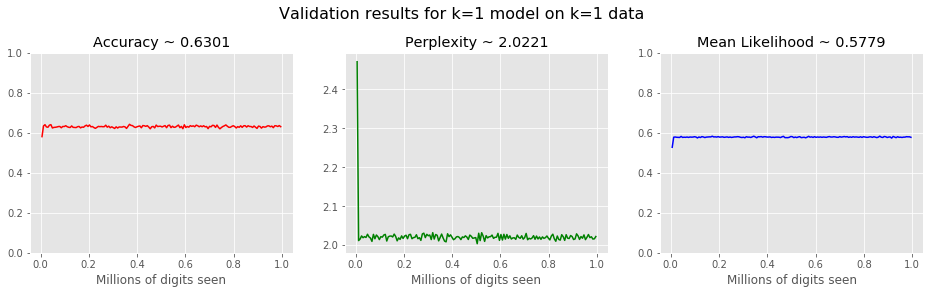

In [12]:
plot_graphs('data/results/run_20180130-205214-eval', 
                         main_title = 'Validation results for k=1 model on k=1 data')

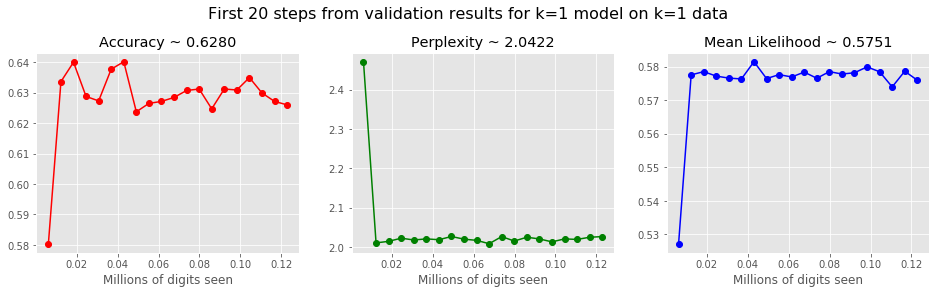

In [13]:
plot_graphs('data/results/run_20180130-205214-eval',
            main_title = 'First 20 steps from validation results for k=1 model on k=1 data',
            step_range = (0,20),
            fit_y_scale_to_data = True,
            marker = 'o-'
           )

### [k=3, 20 first training samples]

Training for k=3 gets a much slower training, but it still gets to capture a pattern.

After training with the first 20M digits, training metrics still do not reach a relative plateau.

In [5]:
empirical_frequencies(load_data(k=3, indices=range(20)))

Loading data for k=3, indices= range(0, 20)


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.05it/s]


Calculating empirical frequencies for 20000 chunks of size 1000


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:14<00:00, 266.99it/s]


,Mean frequency,Standard dev
0,0.103324,0.009969
1,0.099592,0.009410
2,0.099246,0.009446
3,0.098861,0.009479
4,0.098844,0.009363
5,0.098810,0.009194
6,0.098947,0.009500
7,0.099113,0.009459
8,0.099807,0.009255
9,0.103456,0.009478


In [13]:
model = RNNLanguageModel(log_dir = '/tmp/RNNLanguageModel/k3')
model.fit(load_data(k=3, indices=range(20)))

Loading data for k=3, indices= range(0, 20)


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.04s/it]


Initiating model fit...
Data length  : 20000000
Step size    : 32
Batch size   : 192
Run dir      : /tmp/RNNLanguageModel/k3/20180129-032612-train


100%|████████████████████████████████████████████████████████████████████████████| 3255/3255 [3:19:17<00:00,  3.67s/it]


In [3]:
model = RNNLanguageModel(log_dir = '/tmp/RNNLanguageModel/k3')
model.fit(load_data(k=3, indices=range(27,50)), restore_checkpoint=True, step_offset=4500)

Loading data for k=3, indices= range(27, 50)


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:19<00:00,  1.15it/s]


INFO:tensorflow:Restoring parameters from /tmp/RNNLanguageModel/k3/checkpoints/20180130-230137-4500-4500
Initiating model fit...
Data length     : 23000000
Step size       : 32
Batch size      : 192
Hidden layers   : 3
Units per layer : 2048
Run dir         : /tmp/RNNLanguageModel/k3/20180131-010735-train


100%|████████████████████████████████████████████████████████████████████████████| 3743/3743 [4:08:35<00:00,  3.98s/it]


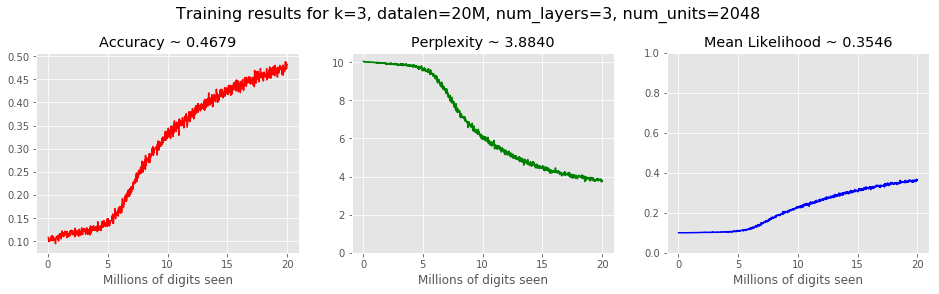

In [28]:
plot_graphs('data/results/run_20180129-032612-train', 
                         main_title = 'Training results for k=3, datalen=20M, num_layers=3, num_units=2048')

Validation results continue to be very stable.

In [69]:
model = RNNLanguageModel(log_dir = '/tmp/RNNLanguageModel/k3')
model.eval(load_data(k=3, indices=[99]))

Loading data for k=3, indices= [99]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]


INFO:tensorflow:Restoring parameters from /tmp/RNNLanguageModel/k3/checkpoints/20180129-032612-3256-3256
Evaluating model...
Data length     : 1000000
Run dir         : /tmp/RNNLanguageModel/k3/20180130-210028-eval


100%|████████████████████████████████████████████████████████████████████████████████| 162/162 [03:09<00:00,  1.17s/it]


Accuracy        : 0.4760
Perplexity      : 3.7873
Mean likelihood : 0.3631


(0.47599283, 3.7872851, 0.36311451)

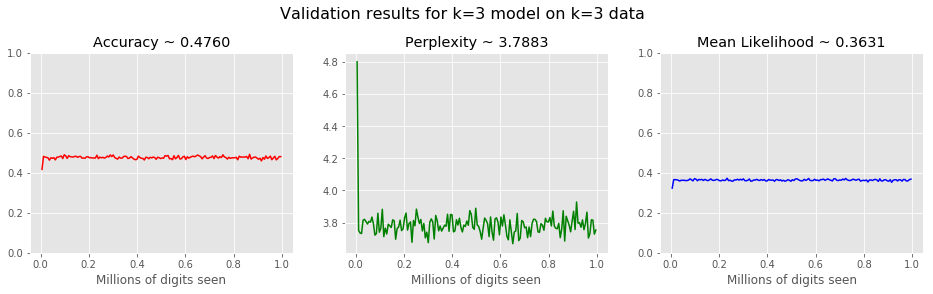

In [70]:
plot_graphs('data/results/run_20180130-210028-eval', 
                         main_title = 'Validation results for k=3 model on k=3 data')

In [81]:
model = RNNLanguageModel(log_dir = '/tmp/RNNLanguageModel/k3')
split_data = load_data(k=3, indices=[95])[0:200000] + load_data(k=3, indices=[96])[0:200000] + load_data(k=3, indices=[97])[0:200000] + load_data(k=3, indices=[98])[0:200000] + load_data(k=3, indices=[99])[0:200000]
model.eval(split_data)

Loading data for k=3, indices= [95]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


Loading data for k=3, indices= [96]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


Loading data for k=3, indices= [97]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


Loading data for k=3, indices= [98]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


Loading data for k=3, indices= [99]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


INFO:tensorflow:Restoring parameters from /tmp/RNNLanguageModel/k3/checkpoints/20180129-032612-3256-3256
Evaluating model...
Data length     : 1000000
Run dir         : /tmp/RNNLanguageModel/k3/20180130-211347-eval


100%|████████████████████████████████████████████████████████████████████████████████| 162/162 [03:09<00:00,  1.17s/it]


Accuracy        : 0.4748
Perplexity      : 3.7894
Mean likelihood : 0.3629


(0.47482842, 3.7893634, 0.36288452)

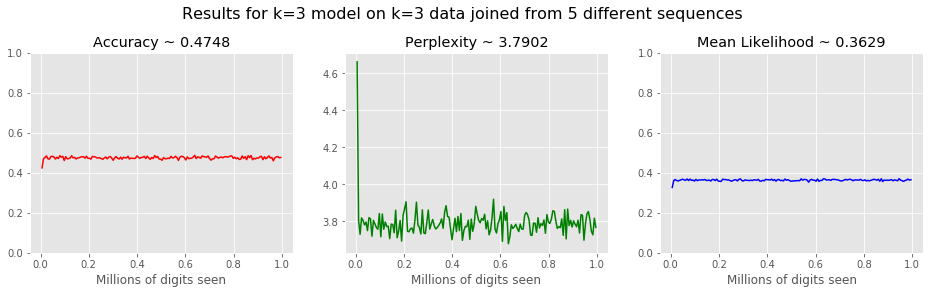

In [104]:
plot_graphs('data/results/run_20180130-211347-eval', 
                         main_title = 'Results for k=3 model on k=3 data joined from 5 different sequences')

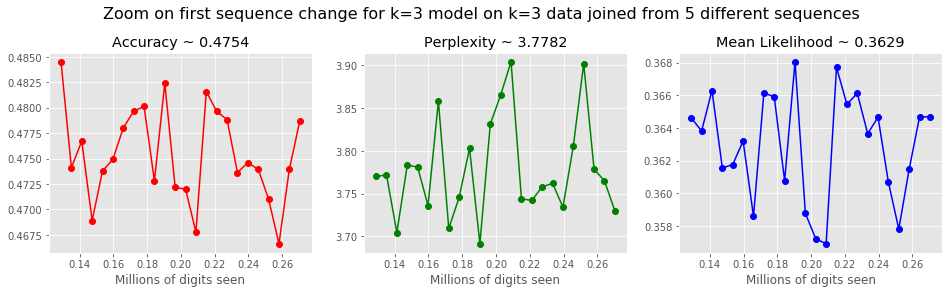

In [6]:
plot_graphs('data/results/run_20180130-211347-eval', 
                         main_title = 'Zoom on first sequence change for k=3 model on k=3 data joined from 5 different sequences',
           step_range = (20,44),
           fit_y_scale_to_data = True,
           marker = 'o-')

In [91]:
model = RNNLanguageModel(log_dir = '/tmp/RNNLanguageModel/k3')
model.eval(load_data(k=4, indices=[99]))

Loading data for k=4, indices= [99]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


INFO:tensorflow:Restoring parameters from /tmp/RNNLanguageModel/k3/checkpoints/20180129-032612-3256-3256
Evaluating model...
Data length     : 1000000
Run dir         : /tmp/RNNLanguageModel/k3/20180130-212901-eval


100%|████████████████████████████████████████████████████████████████████████████████| 162/162 [03:09<00:00,  1.17s/it]


Accuracy        : 0.1004
Perplexity      : 35.9379
Mean likelihood : 0.1002


(0.10037696, 35.937855, 0.10020687)

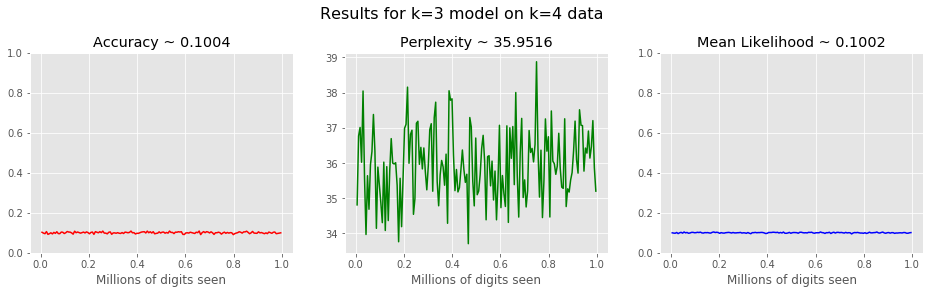

In [93]:
plot_graphs('data/results/run_20180130-212901-eval', 
                         main_title = 'Results for k=3 model on k=4 data')

### [k=4, 50 first training samples]

Training for k=4 gets a much slower training again, but still captures a pattern.

After training with the first 50M digits, accuracy is clearly increasing, but with a value of just ~0.13.

In [7]:
empirical_frequencies(load_data(k=4, indices=range(20)))

Loading data for k=4, indices= range(0, 20)


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.02it/s]


Calculating empirical frequencies for 20000 chunks of size 1000


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:11<00:00, 278.15it/s]


,Mean frequency,Standard dev
0,0.101095,0.009628
1,0.099831,0.009447
2,0.099871,0.009520
3,0.099679,0.009510
4,0.099525,0.009424
5,0.099564,0.009393
6,0.099693,0.009519
7,0.099675,0.009471
8,0.100053,0.009394
9,0.101014,0.009463


In [14]:
model = RNNLanguageModel(log_dir = '/tmp/RNNLanguageModel/k4')
model.fit(load_data(k=4, indices=range(50)), restore_checkpoint=False)

Loading data for k=4, indices= range(0, 50)


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it]


Initiating model fit...
Data length     : 50000000
Step size       : 32
Batch size      : 192
Hidden layers   : 3
Units per layer : 2048
Run dir         : /tmp/RNNLanguageModel/k4/20180130-080916-train


100%|████████████████████████████████████████████████████████████████████████████| 8138/8138 [9:03:44<00:00,  4.01s/it]


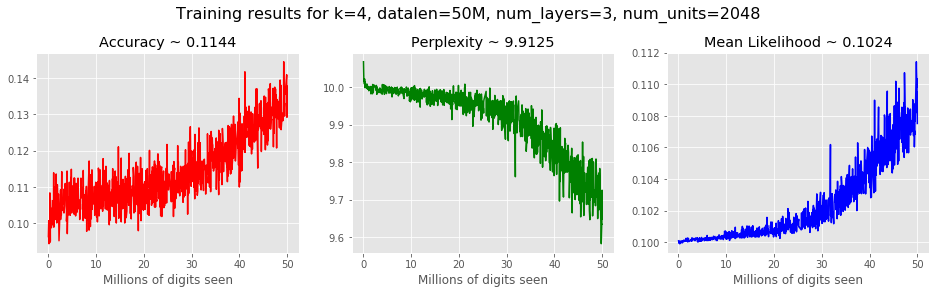

In [7]:
plot_graphs('data/results/run_20180130-080916-train', 
                         main_title = 'Training results for k=4, datalen=50M, num_layers=3, num_units=2048',
            fit_y_scale_to_data = True)

In [4]:
model = RNNLanguageModel(log_dir = '/tmp/RNNLanguageModel/k4')
model.fit(load_data(k=4, indices=range(50,100)), restore_checkpoint=True, step_offset=8138)

Loading data for k=4, indices= range(50, 100)


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.06it/s]


INFO:tensorflow:Restoring parameters from /tmp/RNNLanguageModel/k4/checkpoints/20180130-080916-8139-8139
Initiating model fit...
Data length     : 50000000
Step size       : 32
Batch size      : 192
Hidden layers   : 3
Units per layer : 2048
Run dir         : /tmp/RNNLanguageModel/k4/20180131-051737-train


100%|████████████████████████████████████████████████████████████████████████████| 8138/8138 [9:03:20<00:00,  4.01s/it]


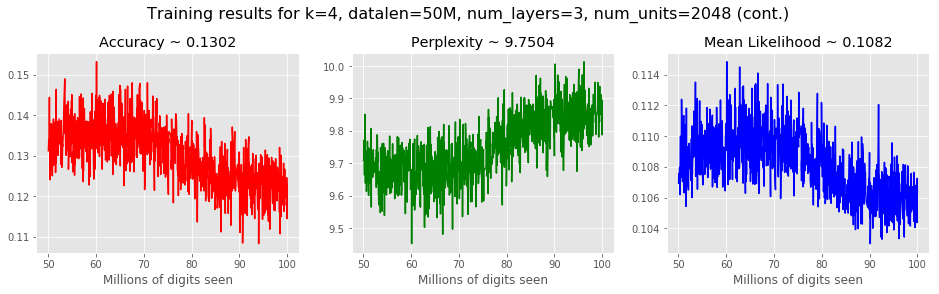

In [6]:
plot_graphs('data/results/run_20180131-051737-train',
            main_title = 'Training results for k=4, datalen=50M, num_layers=3, num_units=2048 (cont.)',
            fit_y_scale_to_data = True
           )

### [k=4, 30 first training samples, 4 layers]

Increasing number of layers to 4 did not bring a better result, although the sudden and drastic fall in performance at ~19M suggests that this might just be a parametrization problem, such as a too big learning rate.

In [3]:
model = RNNLanguageModel(log_dir = '/tmp/RNNLanguageModel/k4', num_units = 2048, num_layers = 4, batch_size = 64)
model.fit(load_data(k=4, indices=range(30)), restore_checkpoint=False)

Loading data for k=4, indices= range(0, 30)


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:25<00:00,  1.15it/s]


Initiating model fit...
Data length     : 30000000
Step size       : 32
Batch size      : 64
Hidden layers   : 4
Units per layer : 2048
Run dir         : /tmp/RNNLanguageModel/k4/20180129-190441-train


100%|█████████████████████████████████████████████████████████████████████████| 14648/14648 [11:21:03<00:00,  2.79s/it]


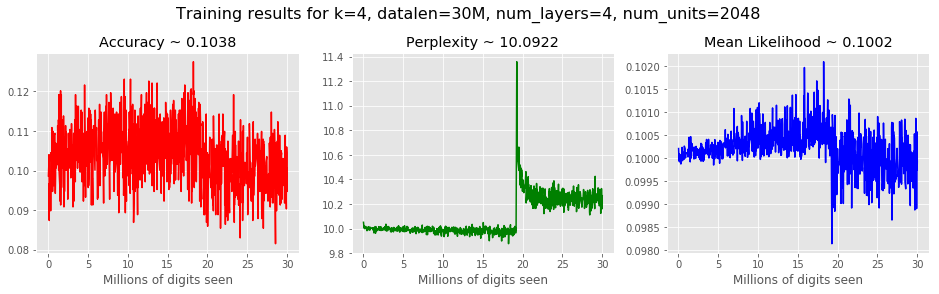

In [8]:
plot_graphs('data/results/run_20180129-190441-train', batch_size=64, 
                         main_title = 'Training results for k=4, datalen=30M, num_layers=4, num_units=2048',
            fit_y_scale_to_data = True)

### [k=5, 95 first training samples, 2 epochs]

In [8]:
empirical_frequencies(load_data(k=5, indices=range(20)))

Loading data for k=5, indices= range(0, 20)


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.02s/it]


Calculating empirical frequencies for 20000 chunks of size 1000


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:25<00:00, 234.88it/s]


,Mean frequency,Standard dev
0,0.100396,0.009545
1,0.099897,0.009454
2,0.099990,0.009524
3,0.099925,0.009494
4,0.099852,0.009563
5,0.099855,0.009511
6,0.099912,0.009569
7,0.099836,0.009505
8,0.099989,0.009421
9,0.100349,0.009485


In [ ]:
model = RNNLanguageModel(log_dir = '/tmp/RNNLanguageModel/k5')
model.fit(k5data * 2)

Initiating model fit...
Data length     : 190000000
Step size       : 32
Batch size      : 192
Hidden layers   : 3
Units per layer : 2048
Run dir         : /tmp/RNNLanguageModel/k5/20180131-193823-train


  6%|████                                                                    | 1760/30924 [4:07:19<68:18:09,  8.43s/it]

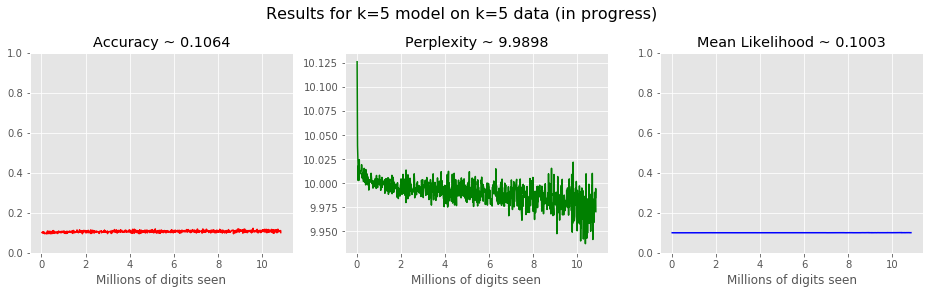

In [12]:
plot_graphs('data/results/run_20180131-193823-train', 
                         main_title = 'Results for k=5 model on k=5 data (in progress)')

### [k=6, 20 first training samples]

In [10]:
empirical_frequencies(load_data(k=6, indices=range(20)))

Loading data for k=6, indices= range(0, 20)


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.02s/it]


Calculating empirical frequencies for 20000 chunks of size 1000


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:29<00:00, 223.82it/s]


,Mean frequency,Standard dev
0,0.099968,0.009491
1,0.100020,0.009493
2,0.099994,0.009611
3,0.100098,0.009460
4,0.099900,0.009552
5,0.100055,0.009392
6,0.100012,0.009526
7,0.100010,0.009541
8,0.099944,0.009465
9,0.099998,0.009505


In [14]:
model = RNNLanguageModel(log_dir = '/tmp/RNNLanguageModel/k6')
model.fit(load_data(k=6, indices=range(20)))

Loading data for k=6, indices= range(0, 20)


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.10s/it]


Initiating model fit...
Data length  : 20000000
Step size    : 32
Batch size   : 192
Run dir      : /tmp/RNNLanguageModel/k6/20180129-064628-train


100%|████████████████████████████████████████████████████████████████████████████| 3255/3255 [3:19:04<00:00,  3.67s/it]


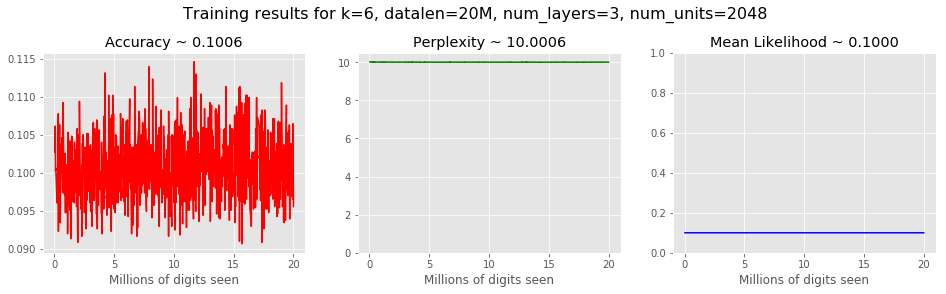

In [29]:
plot_graphs('data/results/run_20180129-064628-train', 
                         main_title = 'Training results for k=6, datalen=20M, num_layers=3, num_units=2048')

### [k=9, 20 first training samples]

In [11]:
empirical_frequencies(load_data(k=9, indices=range(20)))

Loading data for k=9, indices= range(0, 20)


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.10s/it]


Calculating empirical frequencies for 20000 chunks of size 1000


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:34<00:00, 212.36it/s]


,Mean frequency,Standard dev
0,0.099942,0.009531
1,0.100046,0.009559
2,0.100025,0.009425
3,0.099931,0.009465
4,0.099894,0.009419
5,0.100036,0.009531
6,0.100007,0.009476
7,0.100073,0.009535
8,0.100063,0.009562
9,0.099984,0.009437


In [ ]:
model = RNNLanguageModel(log_dir = '/tmp/RNNLanguageModel/k9')
model.fit(load_data(k=9, indices=range(20)))

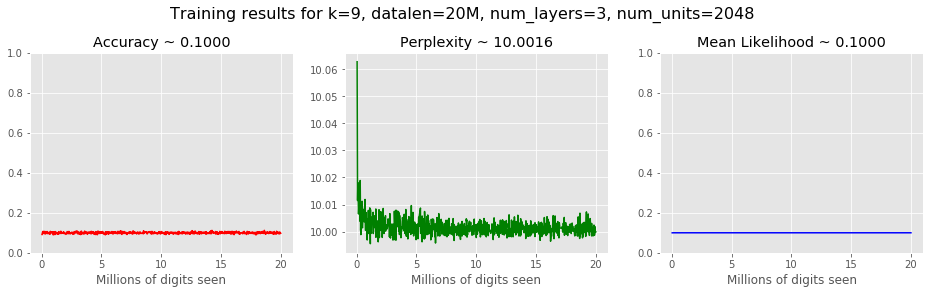

In [10]:
plot_graphs('data/results/run_20180129-100630-train', 
                         main_title = 'Training results for k=9, datalen=20M, num_layers=3, num_units=2048')

## Preliminary results and discussion

* Sequences up to k = 5 have a distinctive histogram of empirical frequencies which establishes a baseline for majority class classification accuracy
* As expected, training needs more steps and reaches decreasing performance as k value increases.
* In those cases, the proposed RNN model reaches much higher accuracy than baseline.
* Evaluation metrics over unseen data produce very similar results over different samples. This suggests again that the found patterns are very consistent along the generated sequences.
* The trained models can be employed to classify the k value of the generating algorithm by measuring the difference between the sequences empirical distribution and the model, i.e., by measuring cross-entropy loss or perplexity.
* For values of k > 5, training was not successful using this preliminary model. Better results might be obtained by improving on training time, increasing network capacity, complexity or architecture.
* Experiments could be designed to examine and visualize the size of the effective receptive field of the employed model, and then examine the effect of this size on the model's performance
* For values of k > 5, training could benefit from receiving and open stream of unseen data directly from the generator algorithm.
* Other approaches that may be explored:
    * Get inspiration from recent application of Generative Adversarial Networks to language models ([Fedus 2018](https://arxiv.org/abs/1801.07736))
    * Autoregressive 1-D convolutional models such as in WaveNet ([van den Oord 2016](https://arxiv.org/abs/1609.03499))